## Results on background simulation

### Energy spectra, track multiplicity, eblob2...

In [1]:
import numpy as np
import pandas as pd

from glob import glob
import matplotlib.pyplot as plt
from invisible_cities.core.system_of_units import year, mBq

In [2]:
def get_tracks_info(isotope, group, index = ['iso', 'vol']):
    paths = sorted(glob('/mnt/lustre/scratch/nlsas/home/usc/ie/mpm/NEXT100/data/full_prod/{}/prod/volumes/*/tracks_info.h5'.format(isotope)))
    df = pd.DataFrame([])    
    for p in paths:
        df_ = pd.read_hdf(p, group)
        vol, iso = p.split('/')[-2], p.split('/')[-5]
        df_['vol'] = vol
        df_['iso'] = iso
        df = df.append(df_)
    df = df.set_index(index)
    return df

In [3]:
def read_act(isotope, act_path, index):
    act = pd.read_excel(act_path, sheet_name=isotope, engine='odf').rename(columns = {'G4Volume': 'vol', 'TotalActivity':'act'})
    act['iso'] = isotope
    act = act.set_index(index).sort_index().drop(['MCEfficiency', 'Version'], axis = 1)
    return act

def read_sim_evs(isotope, stats_path, index):
    with open(stats_path.format(isotope), 'r') as f:
        stats = f.readlines()
        f.close()

    sim_evs = {t.split(' ')[-4].split('/')[-1]:int(t.split(' ')[-2])*int(t.split(' ')[1]) for t in stats}
    sim_df = pd.DataFrame([sim_evs]).T.reset_index().rename(columns = {'index': 'vol', 0:'sim_evs'})
    sim_df['iso'] = isotope
    sim_df = sim_df.set_index(index).sort_index()
    return sim_df

def read_act_eff(isotopes, 
                 act_path = '/home/usc/ie/mpm/NEXT100-0nubb-analysis/nexus_job_templates/ft3/backgrounds/activities_efficiencies_upd2.ods', 
                 stats_path = '/mnt/lustre/scratch/nlsas//home/usc/ie/mpm/NEXT100/data/full_prod/{}/prod/volumes/event_stats.txt', 
                 index = ['iso', 'vol']):
    act_eff = pd.DataFrame([])
    for isotope in isotopes:
        act = read_act(isotope, act_path, index)
        sim = read_sim_evs(isotope, stats_path, index)
        eff = get_tracks_info(isotope, 'selection_rates')
        act_eff = act_eff.append(act.join(sim).join(eff))

    act_eff['exposure'] = act_eff.sim_evs / (act_eff.act * mBq * year)
    return act_eff


In [4]:
isotopes = ['214Bi', '208Tl']
act_eff = read_act_eff(isotopes)

In [5]:
def histogram(df, value, nbins, xrange, weight = None, density = False):
    edges = np.linspace(xrange[0], xrange[1], nbins + 1)
    bincentres = [(edges[i]+edges[i+1])/2. for i in range(len(edges)-1)]

    hist, _ = np.histogram(df[value], nbins, range = xrange, weights = weight, density = density)
    return hist, bincentres

def plot_histogram(bincentres, hist, label, xrange, nfig = 1, scale = 'log', xlabel = '', ylabel = '', title = ''):
    plt.figure(nfig, figsize=(12, 7))
    plt.step(bincentres, hist, where = 'mid', label = label)
    plt.yscale(scale)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xlim(xrange)
    plt.legend()

### MC Energy distribution

In [208]:
mcene_bi = get_tracks_info('214Bi', 'MCEner').join(act_eff.exposure)
mcene_tl = get_tracks_info('208Tl', 'MCEner').join(act_eff.exposure)

mcene_bi = mcene_bi[mcene_bi['energy'] > 0.8]
mcene_tl = mcene_tl[mcene_tl['energy'] > 0.8]

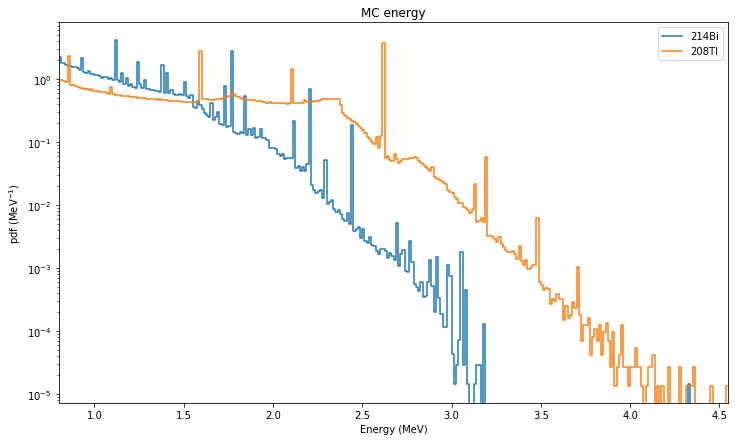

In [209]:
value = 'energy'
nbins = 300
xrange = (0.8, 4.55)

hist_ene_bi, binc = histogram(mcene_bi, value, nbins, xrange, density = True)
hist_ene_tl, binc = histogram(mcene_tl, value, nbins, xrange, density = True)

plot_histogram(binc, hist_ene_bi, '214Bi', xrange)
plot_histogram(binc, hist_ene_tl, '208Tl', xrange\
               , xlabel='Energy (MeV)', ylabel=r'pdf (MeV$^{-1}$)', title = 'MC energy')


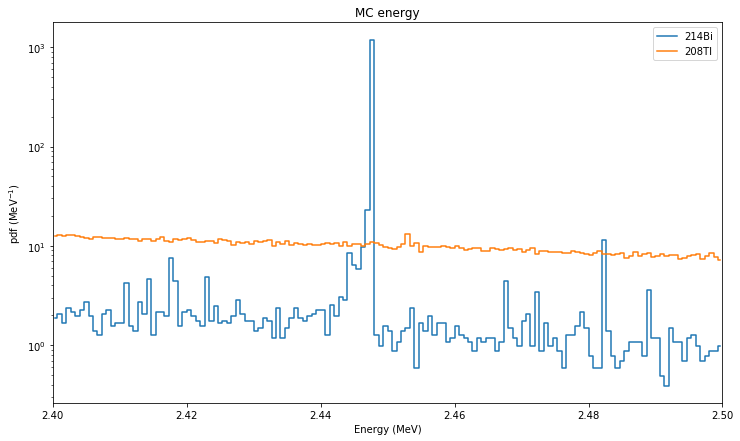

In [226]:
value = 'energy'
nbins = 150
xrange = (2.4, 2.5)

hist_ene_bi, binc = histogram(mcene_bi, value, nbins, xrange, density = True)
hist_ene_tl, binc = histogram(mcene_tl, value, nbins, xrange, density = True)

plot_histogram(binc, hist_ene_bi, '214Bi', xrange)
plot_histogram(binc, hist_ene_tl, '208Tl', xrange\
               , xlabel='Energy (MeV)', ylabel=r'pdf (MeV$^{-1}$)', title = 'MC energy')

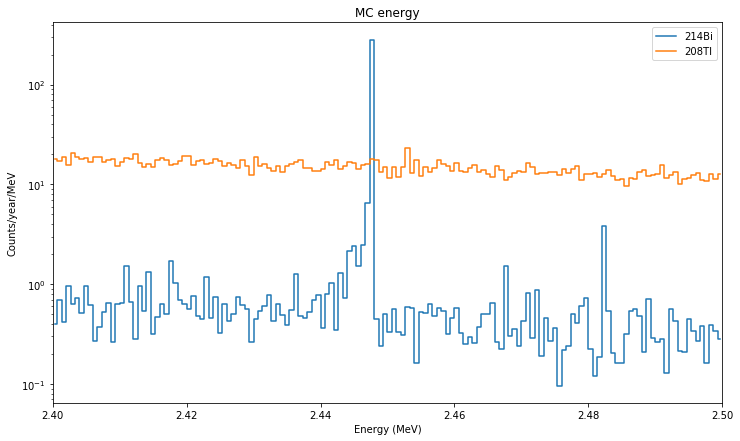

In [238]:
value = 'energy'
nbins = 150
xrange = (2.4, 2.5)

hist_ene_bi, binc = histogram(mcene_bi, value, nbins, xrange, weight=1/mcene_bi.exposure, density = False)
hist_ene_tl, binc = histogram(mcene_tl, value, nbins, xrange, weight=1/mcene_tl.exposure, density = False)

plot_histogram(binc, hist_ene_bi, '214Bi', xrange)
plot_histogram(binc, hist_ene_tl, '208Tl', xrange\
               , xlabel='Energy (MeV)', ylabel=r'Counts/year/MeV', title = 'MC energy')

### RECO Energy distribution

In [7]:
reene_bi = get_tracks_info('214Bi', 'RecoEner').join(act_eff.exposure)
reene_tl = get_tracks_info('208Tl', 'RecoEner').join(act_eff.exposure)

reene_bi = reene_bi[reene_bi['energy'] > 0.8]
reene_tl = reene_tl[reene_tl['energy'] > 0.8]

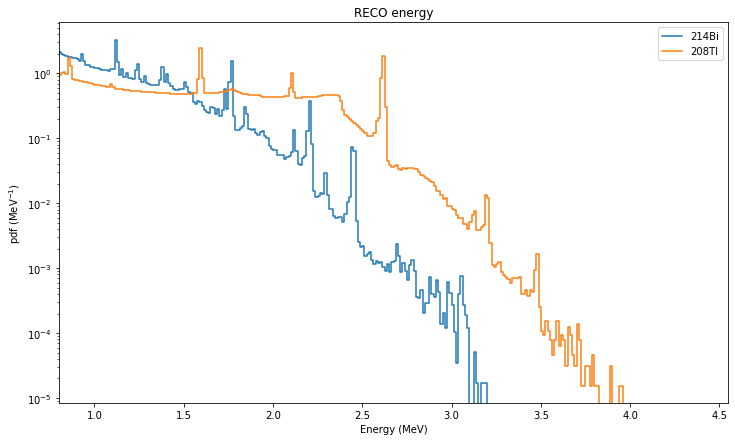

In [8]:
value = 'energy'
nbins = 300
xrange = (0.8, 4.55)

hist_ene_bi, binc = histogram(reene_bi, value, nbins, xrange, density = True)
hist_ene_tl, binc = histogram(reene_tl, value, nbins, xrange, density = True)

plot_histogram(binc, hist_ene_bi, '214Bi', xrange)
plot_histogram(binc, hist_ene_tl, '208Tl', xrange\
               , xlabel='Energy (MeV)', ylabel=r'pdf (MeV$^{-1}$)', title = 'RECO energy')

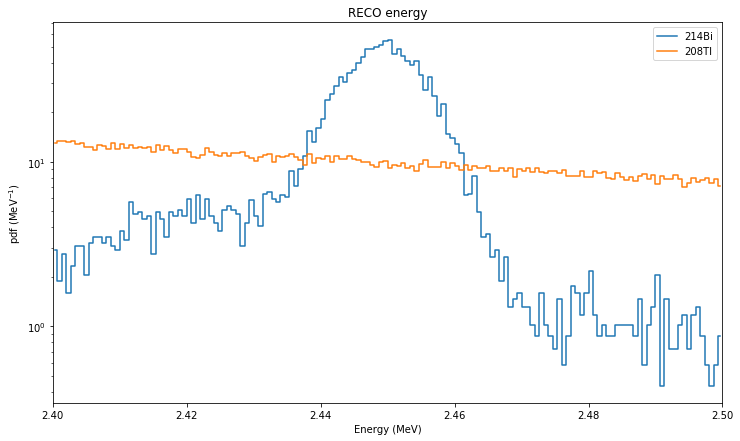

In [9]:
value = 'energy'
nbins = 150
xrange = (2.4, 2.5)

hist_ene_bi, binc = histogram(reene_bi, value, nbins, xrange, density = True)
hist_ene_tl, binc = histogram(reene_tl, value, nbins, xrange, density = True)

plot_histogram(binc, hist_ene_bi, '214Bi', xrange)
plot_histogram(binc, hist_ene_tl, '208Tl', xrange\
               , xlabel='Energy (MeV)', ylabel=r'pdf (MeV$^{-1}$)', title = 'RECO energy')

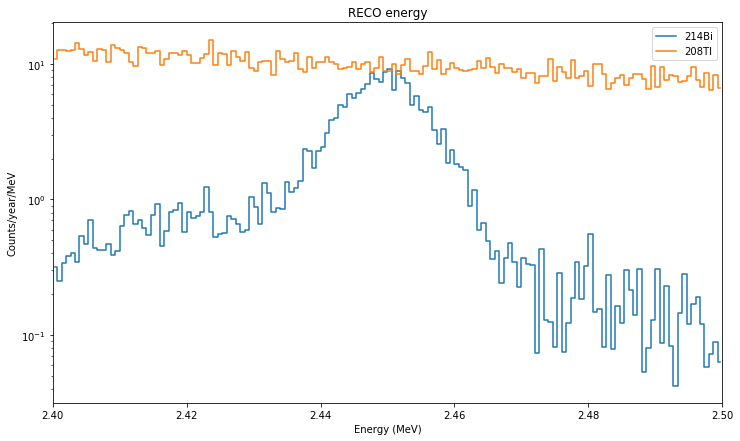

In [10]:
value = 'energy'
nbins = 150
xrange = (2.4, 2.5)

hist_ene_bi, binc = histogram(reene_bi, value, nbins, xrange, weight=1/reene_bi.exposure, density = False)
hist_ene_tl, binc = histogram(reene_tl, value, nbins, xrange, weight=1/reene_tl.exposure, density = False)

plot_histogram(binc, hist_ene_bi, '214Bi', xrange)
plot_histogram(binc, hist_ene_tl, '208Tl', xrange\
               , xlabel='Energy (MeV)', ylabel=r'Counts/year/MeV', title = 'RECO energy')

### RECO FID Energy distribution (comparation)

In [11]:
reenefid_bi = get_tracks_info('214Bi', 'RecoEnerFid').join(act_eff.exposure)
reenefid_tl = get_tracks_info('208Tl', 'RecoEnerFid').join(act_eff.exposure)

reenefid_bi = reenefid_bi[reenefid_bi['energy'] > 0.8]
reenefid_tl = reenefid_tl[reenefid_tl['energy'] > 0.8]

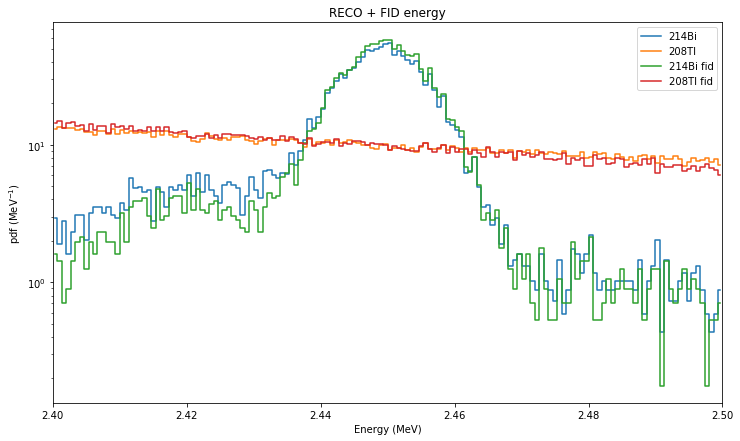

In [16]:
value = 'energy'
nbins = 150
xrange = (2.4, 2.5)

hist_ene_bi, binc = histogram(reene_bi, value, nbins, xrange, density = True)
plot_histogram(binc, hist_ene_bi, '214Bi', xrange)

hist_ene_tl, binc = histogram(reene_tl, value, nbins, xrange, density = True)
plot_histogram(binc, hist_ene_tl, '208Tl', xrange)

hist_ene_bi, binc = histogram(reenefid_bi, value, nbins, xrange, density = True)
plot_histogram(binc, hist_ene_bi, '214Bi fid', xrange)

hist_ene_tl, binc = histogram(reenefid_tl, value, nbins, xrange, density = True)
plot_histogram(binc, hist_ene_tl, '208Tl fid', xrange\
               , xlabel='Energy (MeV)', ylabel=r'pdf (MeV$^{-1}$)', title = 'RECO + FID energy')

### Track multiplicity

In [18]:
ntracks_bi = get_tracks_info('214Bi', 'NumTracks')
ntracks_tl = get_tracks_info('208Tl', 'NumTracks')

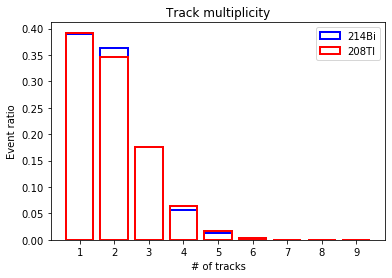

In [24]:
nbins = ntracks_bi.numb_of_tracks.max()
xrange = (0, ntracks_bi.numb_of_tracks.max())
tr_hist, tr_bin = np.histogram(ntracks_bi.numb_of_tracks, range = xrange, bins = nbins) 
plt.bar(tr_bin[1:-1], tr_hist[1:]/ len(ntracks_bi), fill = False, label = '214Bi', edgecolor='b', linewidth = 2)

nbins = ntracks_tl.numb_of_tracks.max()
xrange = (0, ntracks_tl.numb_of_tracks.max())
tr_hist, tr_bin = np.histogram(ntracks_tl.numb_of_tracks, range = xrange, bins = nbins) 
plt.bar(tr_bin[1:-1], tr_hist[1:]/ len(ntracks_tl), fill = False, label = '208Tl', edgecolor='r', linewidth = 2)

plt.xlabel('# of tracks')
plt.ylabel('Event ratio')
plt.title('Track multiplicity')
plt.xticks(tr_bin[1:-1])
plt.legend()